# Case study: FitBit Tracker Data for Bellabeat in R
Hi, everyone!
Let me introduce you my Case Study project with FitBit Tracker Data for Bellabeat.

# About the company

Urška Sršen and Sando Mur founded Bellabeat, a high-tech company that manufactures health-focused smart products. Sršen used her background as an artist to develop beautifully designed technology that informs and inspires women around the world. Collecting data on activity, sleep, stress, and reproductive health has allowed Bellabeat to empower women with knowledge about their own health and habits.

# Product
Bellabeat launched multiple products, but for my Case Study I will choose only wellness tracker. Wearable trackers are an increasingly popular tool among healthy adults and are used to facilitate self-monitoring of physical activity.

# Ask
In my analysis I will try to answer questions:
* What are some trends in smart devise usage?
* How could these trends apply to Bellabeat customers?

Business task
* Expand grouth oppotunities for Bellabeat weallness tracker

# Prepare
18 CSV files are available from [FitBit Fitness Tracker Data](https://www.kaggle.com/datasets/arashnic/fitbit?datasetId=1041311&searchQuery=Case+study%3A+FitBit+Tracker+Data+for+Bellabeat+in+R) (CC0: Public Domain, dataset made available through Mobius). This Kaggle data set contains personal fitness tracker from thirty Fitbit users consented to the submission of personal tracker data.
This data has limitations: only 33 users and 31 days of 2016 year.

# Process
### Loading packages

In [ ]:
library(tidyverse)
library(readr)
library(lubridate)
library(tidyr)
library(dplyr)
library(ggrepel)
library(forcats)
library(scales)

### Importing data


In [ ]:
daily_act <- read.csv('./dailyActivity_merged.csv')
sleep_day <- read_csv('./sleepDay_merged.csv')
sleep_min <- read_csv('./minuteSleep_merged.csv')
step_min <- read.csv('./minuteStepsNarrow_merged.csv')
intens_min <- read_csv('./minuteIntensitiesNarrow_merged.csv')
heart_rate <- read_csv('./heartrate_seconds_merged.csv')
weight <- read_csv('./weightLogInfo_merged.csv')
calories_min <- read_csv('./minuteCaloriesNarrow_merged.csv')


In [ ]:
daily_act = pd.read_csv('./dailyActivity_merged.csv')
sleep_day = pd.read_csv('./sleepDay_merged.csv')
sleep_min = pd.read_csv('./minuteSleep_merged.csv')
step_min = pd.read_csv('./minuteStepsNarrow_merged.csv')
intens_min = pd.read_csv('./minuteIntensitiesNarrow_merged.csv')
heart_rate = pd.read_csv('./heartrate_seconds_merged.csv')
weight = pd.read_csv('./weightLogInfo_merged.csv')
calories_min = pd.read_csv('./minuteCaloriesNarrow_merged.csv')

In [ ]:
#number od users in each file
n_distinct(daily_act$Id)
n_distinct(sleep_day$Id)
n_distinct(sleep_min$Id)
n_distinct(step_min$Id)
n_distinct(intens_min$Id)
n_distinct(heart_rate$Id)
n_distinct(weight$Id)
n_distinct(calories_min$Id)

Number of users in data files are different. We need to take this into account.

Let's see any duplicates in using data

In [ ]:
sum(duplicated(daily_act))
sum(duplicated(sleep_day))
sum(duplicated(sleep_min))
sum(duplicated(step_min))
sum(duplicated(intens_min))
sum(duplicated(heart_rate))
sum(duplicated(weight))
sum(duplicated(calories_min))

We need to remove these duplicates.

In [ ]:
sleep_day <- sleep_day %>%
  distinct() 
sleep_min <- sleep_min %>%
  distinct() 

# Analyse

For beginning I will use daily activity file and SleepDay file. I want to analyse how much days users wear their tracker and how they spend their day.

In [ ]:
Id_days <- daily_act %>% 
  group_by(Id) %>% 
  summarize(days=sum(n())) %>% 
  mutate(category=case_when(
    days>=1 & days<=10 ~ "low use",
    days>=11 & days<=20 ~ "moderate use",
    days>=21 & days<=31 ~ "high use"))

Id_days_new <- Id_days %>% 
  group_by(category) %>% 
  summarize(user_number=sum(n()))
head(Id_days_new)

We can see that 29 users are in "high use" catagory.

Next, I'm going to merge daily_act and sleep_day data frames because I need to see all users activity during 24 hour.
I need identical Id and Date column to merge data frames.

In [ ]:
daily_act$ActivityDate <- mdy(daily_act$ActivityDate)
sleep_day1 <- separate(sleep_day, SleepDay, into=c('ActivityDate','time', 'am_pm'), sep=" ", remove=TRUE)
sleep_day1$ActivityDate <- mdy(sleep_day1$ActivityDate)

#merge 2 tables.
full_day <- daily_act %>% full_join(sleep_day1, by=c('Id'='Id', 'ActivityDate'='ActivityDate'))
full_day[is.na(full_day)] <-0
head(full_day)

To chek how much time users wear tracker during the day I'm going to add new column with total activity and sleeping time represented in hours. Then I need to check is there any divergence from 24 hours? Yes, there is. We can see 155 rows more than 24 hours and 181 less than 24 hours. Something is wrong with the data.

In [ ]:
full_day <- mutate(full_day, total_time=(VeryActiveMinutes+FairlyActiveMinutes+LightlyActiveMinutes+SedentaryMinutes+TotalTimeInBed)/60)

#filter on days that is not 24 hours in total. 
full_day_check1 <- filter(full_day, total_time > 24)
glimpse(full_day_check1)

full_day_check2 <- filter(full_day, total_time < 24)
glimpse(full_day_check2)


To look deeper I use file with minutes of sleep. I will group it by day and compare with SleepDay data.

In [ ]:
summary(sleep_min)

In summary we can see that there was values from 1 to 3 in "value" column. I think that these numbers mean some quality of sleeping munutes. I decided to add new colunm with quantity of sleeping minutes. I copeid "value" and replace all values that not equel 0 to 1. This new column meant: did person sleep in this minute or not (0/1 value). Now I can count minutes of sleeping time.

In [ ]:
sleep_min <- sleep_min
sleep_min <- sleep_min %>% 
  mutate(minutes=value)
sleep_min$minutes[sleep_min$minutes!=0] <- 1
summary(sleep_min)

In order to be able to merge my data frames I need to change the column with date to merge sleep_min with full_day data and use group by days and Id. 

In [ ]:
sleep_min <- separate(sleep_min, date, into=c('SleepDate','time', 'am_pm'), sep=" ", remove=TRUE)
sleep_min$SleepDate <- mdy(sleep_min$SleepDate)

sleep_min1 <- sleep_min %>% 
  group_by(Id, SleepDate) %>% 
  summarise(total_sleep= sum(minutes))

full_day_new <- full_day %>% full_join(sleep_min1, by=c('Id'='Id', 'ActivityDate'='SleepDate'))
full_day_new[is.na(full_day_new)] <-0
head(full_day_new)

I need to make new column with total activity and new sleep data and I'm going to use filters again to see does it fit 24 hours or not. Yes, we can see other values, but now we have only 76 values less than 24 hours and 0 values more than 24 hours.
I can make a conclusion that there was a mistake in sleep_day data and because of that I'm going to use new data from sleep_min.

In [ ]:
full_day_new <- mutate(full_day_new, total_time_check=(VeryActiveMinutes+FairlyActiveMinutes+LightlyActiveMinutes+SedentaryMinutes+total_sleep)/60)

#filter on days that is no 24 hours
full_day_check3 <- filter(full_day_new, total_time_check > 24)
glimpse(full_day_check3)
full_day_check4 <- filter(full_day_new, total_time_check < 24)
glimpse(full_day_check4)

Let's use new data to analyse how many time in a day users spend on sleeping and sitting.

In [ ]:
avarage_sleep <- full_day_new %>% 
  group_by(Id) %>% 
  summarize(mean_sleep=mean(total_sleep)/60, mean_sedentary=mean(SedentaryMinutes)/60)
head(avarage_sleep)

I want to compare hole day and sleeping time also.

In [ ]:
avarage_day <- full_day_new %>% 
  group_by(Id) %>% 
  summarize(mean_sleep=mean(total_sleep)/60, mean_day=mean(total_time_check))
head(avarage_day)

### Activity analysis
I decide to analize users activity using data with minutes detalization. I plan to merge intensity, steps, heart rate and calories.

In [ ]:
head(step_min)
head(intens_min)
head(calories_min)
head(heart_rate)

I need to separete the "date" colunm into day and time component, change format and merge data frames.
I'm going to add new colunm with quantity of active minutes in step_min data. I need to copy "steps" and replace all values that not equel 0 to 1. This new column means: did person do steps in this minute or not (0/1 value). Now I can count minutes of active time.

And next I will merge steps data with intensity.

In [ ]:
step_min <- separate(step_min, ActivityMinute, into=c('ActivityDate','time', 'am_pm'), sep=" ", remove=TRUE)

step_min$ActivityDate <- mdy(step_min$ActivityDate)
step_min$time <- hms(step_min$time)

step_min <- mutate(step_min, activity=Steps)
step_min$activity[step_min$activity!=0] <- 1

intens_min <- separate(intens_min, ActivityMinute, into=c('ActivityDate','time', 'am_pm'), sep=" ", remove=TRUE)

intens_min$ActivityDate <- mdy(intens_min$ActivityDate)
intens_min$time <- hms(intens_min$time)

#merge intensity and steps data frames
intensity_steps <- intens_min %>% full_join(step_min, by=c('Id'='Id', 'ActivityDate'='ActivityDate', 'time'='time', "am_pm"='am_pm'))


I need to check is there any intensity without steps. And in fact there is such activity. Next, I'm going to add calories information and check again. Curiously, there are some calories in that minutes. It could be some exercises in fitness club, for example.

In [ ]:
check1 <- filter(intensity_steps, activity==0, Intensity!=0)
summary(check1)
calories_min <- separate(calories_min, ActivityMinute, into=c('ActivityDate','time', 'am_pm'), sep=" ", remove=TRUE)
calories_min$ActivityDate <- mdy(calories_min$ActivityDate)
calories_min$time <- hms(calories_min$time)
#merge
int_steps_calories <- intensity_steps %>% full_join(calories_min, by=c('Id'='Id', 'ActivityDate'='ActivityDate', 'time'='time', "am_pm"='am_pm'))
check2 <- filter(int_steps_calories, activity==0, Intensity!=0)
summary(check2)

I decided that I want to consider those intensity and add minutes with this kind of intensity in activity column. If intensity not equel 0 I will change activity value to 1.

In [ ]:
intensity_steps$activity[intensity_steps$activity == 0 & intensity_steps$Intensity!=0] <- 1

Let's add heart rate informatiom

In [ ]:
head(heart_rate)

heart_rate <- separate(heart_rate, Time, into=c('ActivityDate','time', 'am_pm'), sep=" ", remove=TRUE)
heart_rate <- heart_rate %>% 
  mutate(time_new=time) %>% 
  separate(time_new, into=c('hour', 'minute', 'sec'), sep=":")
heart_rate$sec[heart_rate$sec!=00] <- 0
heart_rate_new <- unite(heart_rate, time_new, c('hour', 'minute', 'sec'), sep=":")
heart_rate_new$time_new <- hms(heart_rate_new$time_new)
heart_rate_min <- heart_rate_new %>% 
  distinct() %>% 
  group_by(Id, ActivityDate, time_new, am_pm) %>% 
  summarize(mean_value=mean(Value))
heart_rate_min$ActivityDate <- mdy(heart_rate_min$ActivityDate)

#merge intensity/steps with heart rate
int_steps_heart <- intensity_steps %>% full_join(heart_rate_min, by=c('Id'='Id', 'ActivityDate'='ActivityDate', 'time'='time_new', "am_pm"='am_pm'))
int_steps_heart[is.na(int_steps_heart)] <-0
head(int_steps_heart)

For future visualization I thought it would be interesting to add user category to activity data.

In [ ]:
int_active_days <- int_steps_heart %>% 
  group_by(Id,ActivityDate, Intensity) %>% 
  summarize(act_minutes=sum(activity), steps=sum(Steps))
int_active_days$ActivityDate <- as.character(int_active_days$ActivityDate)
int_active_days$Intensity <- as.character(int_active_days$Intensity)
#merge Id catagory from full_day data frame with int_active_days
int_active_days_cat <- int_active_days %>% full_join(Id_days, by=c('Id'='Id'))
#average activity minutes by date, category and user
int_active_days_cat1 <- int_active_days_cat %>% 
  group_by(ActivityDate, category, Intensity) %>% 
  summarize(active_minutes=mean(act_minutes),steps=mean(steps))
head(int_active_days_cat1)

As a last step I decided to see avarage activity and steps for "high use" catagory of users

In [ ]:
int_active_days1 <- int_active_days_cat1 %>% 
  filter(category=="high use") %>% 
  group_by(Intensity) %>% 
  summarize(mean_activityt=mean(active_minutes), mean_steps=mean(steps))
head(int_active_days1)

We see that very and fairly active time together is about 1 hour a day. Most of activity is light.

# Share

## About fitness tracker market.

Acording to Grand View Research report the global fitness tracker market size to be valued at USD 138.7 billion by 2028 and is expected to grow at a compound annual growth rate (CAGR) of 18.9% during the forecast period (to see report information click [here](https://www.grandviewresearch.com/industry-analysis/fitness-tracker-market)).
The market growth is extensively attributed to the rising health & fitness awareness, growing penetration of the internet & smartphones, and increased consumer disposable income levels. 
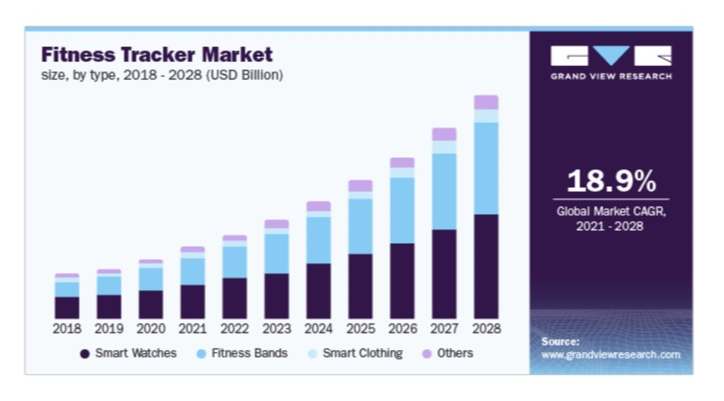

## Users demographic information

In our data we don't have any users demigraphic information. That's why I searched for additional data.
I found [50+ Wearable Fitness Tracker Statistics 2021](https://runrepeat.com/fitness-tracker-statistics) article from 2021 year with these trackers demographics:

  #### Age and gender
* Women are 38.88% more likely to wear a wearable fitness tracker than men
* 25% of women responded positively to wearing fitness trackers
* 18% of men responded positively to wearing fitness trackers
* Women 55 years of age or younger are the most likely to use wearable fitness devices while men above the age of 55 are the least likely
#### Income
* 31% of those earning 75,000 dollars or more per year use a wearable device for fitness tracking.
* Only 12% of those making 30,000 dollars or less per year use a wearable fitness tracker
* ~50% of upper income households use fitness trackers and health apps
* ~33 of middle-income households use fitness trackers and health apps
* ~25% of low-income households use fitness trackers and health apps
#### Education
* College graduates are significantly more likely to wear a fitness tracker device than those who only have a high school degree or less
* Race and ethnicity
* Hispanic adults use fitness trackers the most (26%)
* Black adults come in 2nd with 23% using a fitness tracker
* White adults are the least likely to use a fitness tracker (20%)
#### Geographical location
* Those in cities and suburban areas are more likely to use a fitness tracker or smartwatch with fitness tracking capabilities (35%) in comparison to those in rural areas (30%)




## How do users spend their day?

In [ ]:
# add new column with percents
Id_days_chart <- mutate(Id_days_new, prop = percent(user_number/ sum(user_number)))
# arrange data
Id_days_chart <- Id_days_chart %>%
  arrange(desc(user_number)) 

pie <- ggplot(Id_days_chart, aes(x = "", y = user_number, fill = fct_inorder(category))) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar("y", start = 0) +
  geom_label_repel(aes(label = prop), size=5, show.legend = F, nudge_x = 1) +
  guides(fill = guide_legend(title = "category"))+
  theme(legend.position = "bottom")+
  labs(title="Time of using tracker")
pie

As we can see on the chart 29 users are in "high use" category. It's 87,8% of survey participants.

## Sleeping and Sedentary time
On the chart we can see that mean sedentary time for most users is around 20 hours a day. That looks unreal.  

In [ ]:
avarage_sleep$Id <- as.character(avarage_sleep$Id)
avarage_sleep_long <- avarage_sleep %>%
  gather("Type", "Value", -Id)

avarage_sleep_chart <- ggplot(avarage_sleep_long, aes(y = Id, x = Value, fill = Type, colour = Type)) + 
  geom_bar(stat = "identity", position = "dodge")+
  theme(legend.position = "top")+
  labs(x="Hours", y="User Id", title="Sleeping and sedentary time")
avarage_sleep_chart 

Comparing total day column and sleeping time we can see that total time of wearing the tracker is about 24 hours with or without sleeping time. That means we can't analyse sedentary time because in some cases it includes user's sleeping time. I think that tracker's sensor doesn't work as it's suppose to in some cases. 

In [ ]:
avarage_day$Id <- as.character(avarage_day$Id)
avarage_day_long <- avarage_day %>%
  gather("Type", "Value", -Id)

avarage_day_chart <- ggplot(avarage_day_long, aes(y = Id, x = Value, fill = Type, colour = Type)) + 
  geom_bar(stat = "identity", position = "dodge")+
  geom_vline(xintercept = 24)+
  theme(legend.position = "top")+
  labs(x="Hours", y="User Id", title="Whole day and sleeping time")
avarage_day_chart 

## Activity

I want to show heart rate values for different kind of intensity.
I used filter because number of users with heart rate data is less than active users in other files.

In [ ]:
int_heart <- int_steps_heart %>% 
  filter(mean_value!=0) %>% 
  group_by(Intensity) %>% 
  summarize(mean_heart=mean(mean_value), max_rate=max(mean_value), min_rate=min(mean_value))
head(int_heart)

Let's compare these values with recommendations of American Heart Association from [Target Heart Rates Chart](https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates#:~:text=Your%20maximum%20heart%20rate%20is%20about%20220%20minus%20your%20age.&text=In%20the%20age%20category%20closest,70%2D85%25%20of%20maximum.) article.

Avarage values is in recommended range. But minimun values seem to be too low.

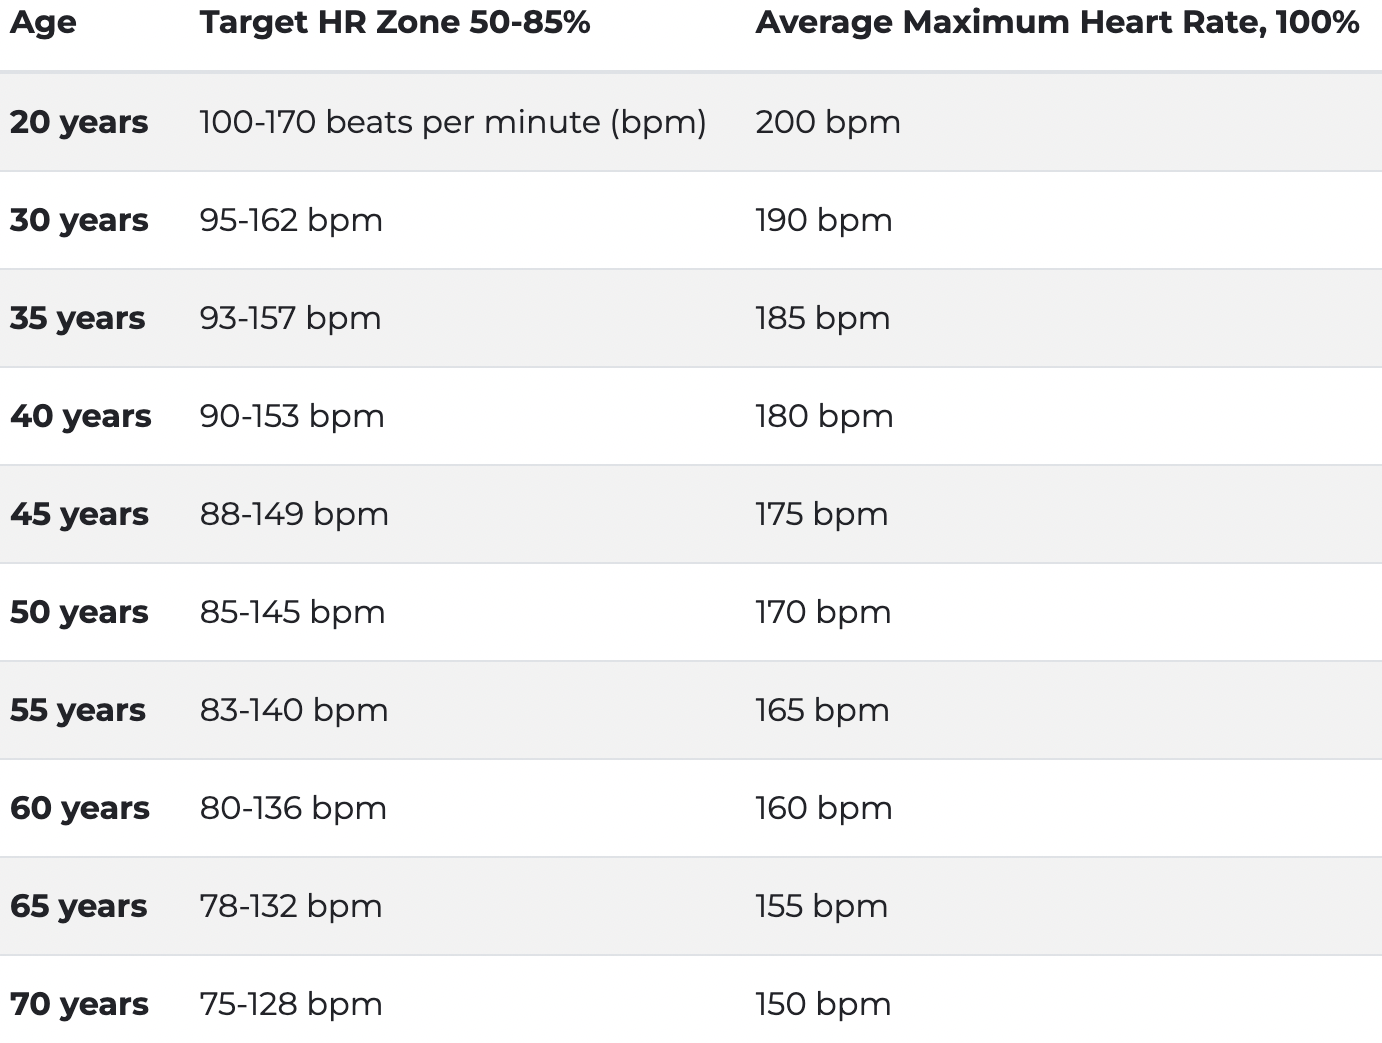


Next I make a chart to see activity by every Id catagory.

In [ ]:
int_active_chart <- ggplot(int_active_days_cat1, aes(y = ActivityDate, x = active_minutes, fill = Intensity, colour= Intensity)) + 
  geom_bar(stat = "identity", position = "dodge")+
  facet_wrap(~category)
  theme(legend.position = "top")+
  labs(x="Intensity", y="Date", title="Activity by days")
int_active_chart   

On this chart we can see that "moderate use" group of users join this data set from 1.05.2016 (not from 12.04.2016). 

Also there is not a big difference between average activity of "high use" group though the days. It seems that 29 users is active every day no matter what.

# Summarizing recommendations

When looking to buy a fitness tracker user should consider (from [50+ Wearable Fitness Tracker Statistics 2021](https://runrepeat.com/fitness-tracker-statistics) article):

1. Battery life - How many days can I wear this without charging my watch or band?
1. Waterproofing - Can I swim while wearing this? Is it water resistant?
1. Display size - Does it have an easy way to view time/date?
1. Heart Rate Monitor - Do I need one? What type will work best for me?
1. GPS Tracking - Will I be able to see where I've been?
1. Sleep Monitoring - Am I going to get enough shut eye
1. Calorie Counter - Are they accurate?
1. Activity Tracker - Do I really need one?
1. Smartwatch vs Fitness Band - Which would suit me better?

****According to my analysis Bellabeat can improve these "what to look for" points:****
* Pay attention to design of the tracker. It shoud be comfortabe and have a good sensor contact with skin so it can improve self-monitoring. 
* Add instractions on how to wear the tracker to the product and to the App to avoid measurement mistackes.
* I recommend to improve quality of the sensor because we saw in analysis that there are problems with sleep monitoring and heart rate measurements.
* Additional survey about battery life and waterproofing of Bellabeat tracker.


Thank you for your attention!
Hope to see your comments